# Time Series Modeling with the SARIMAX Model

In [1]:
import pandas as pd
import numpy as np
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Getting the Data

In [2]:
url = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/AirPassengers.csv'

In [3]:
passengers = pd.read_csv(url)

In [4]:
passengers.head()

,Unnamed: 0,time,AirPassengers
0,1,1949.000000,112
1,2,1949.083333,118
2,3,1949.166667,132
3,4,1949.250000,129
4,5,1949.333333,121


In [5]:
passengers = passengers.drop('Unnamed: 0', axis=1)

# Converting Number of Months to a PeriodIndex

In [6]:
month, year = np.modf(passengers['time'])

In [7]:
month = np.round(month*12+1).astype(np.int)

In [8]:
year = year.astype(np.int)

In [9]:
from datetime import date

dates = [date(y, m, 1) for y, m in zip(year, month)]

In [10]:
periods = pd.PeriodIndex(dates, freq='M')

In [11]:
passengers.index = periods

In [12]:
passengers = passengers.drop('time', axis=1).squeeze()

# Plot the Time Series

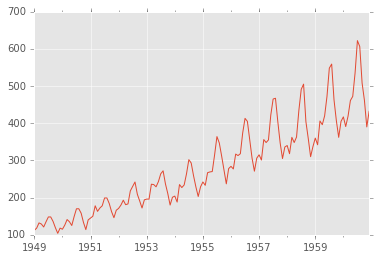

In [13]:
passengers.plot()

# Handling Trend and Seasonality

In [14]:
lagged = passengers.diff(1)[1:]

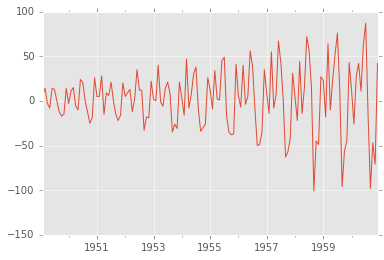

In [15]:
lagged.plot()

In [16]:
seasonal_removed = lagged.diff(12)[12:]

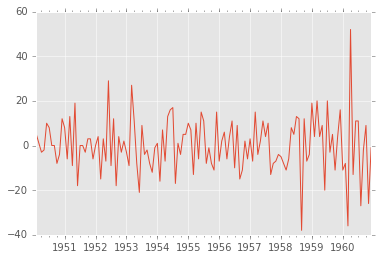

In [17]:
seasonal_removed.plot()

# Dickie-Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

adf, p_val, lag, nobs, critical_vals, icbest = adfuller(seasonal_removed)

d:\Anaconda3\envs\latest\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [19]:
print('DF test statistic: {:.4f}, p_val: {:.4f}, lag={}'.format(adf, p_val, lag))

DF test statistic: -15.5956, p_val: 0.0000, lag=0


# Autocorrelation and Partial Autocorrelation

In [20]:
from statsmodels.tsa.stattools import acf, pacf

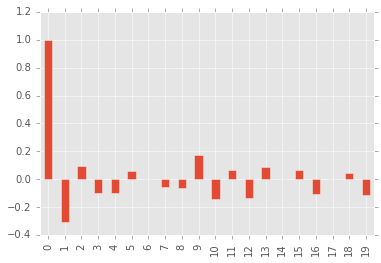

In [21]:
acfs = acf(seasonal_removed)[:20]
pd.Series(acfs, index=range(20)).plot(kind='bar')

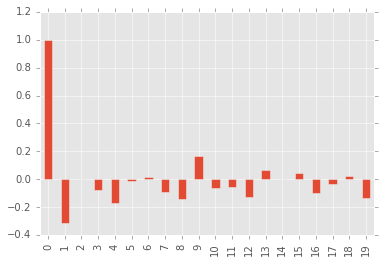

In [22]:
pacfs = pacf(seasonal_removed)[:20]
pd.Series(pacfs, index=range(20)).plot(kind='bar')

# Build the SARIMAX model

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(passengers, trend='n', order=(0, 1 ,0), seasonal_order=(1, 1, 1, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      AirPassengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -513.064
Date:                            Sat, 19 Aug 2017   AIC                           1032.128
Time:                                    09:55:21   BIC                           1041.037
Sample:                                01-31-1949   HQIC                          1035.748
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4437      0.527     -0.842      0.400      -1.477       0.589
ma.S.L12       0.2738      0.572      0.478      0.632      -0.848       1.396
sigma2       147.1839     12.321     11.945      0.000     123.034     171.334
===================================================================================
Ljung-Box (Q):                       71.16   Jarque-Bera (JB):                33.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
passengers_predicted = results.predict()

In [25]:
results_df = pd.concat([passengers, passengers_predicted], keys=['actual', 'predicted'], axis=1)

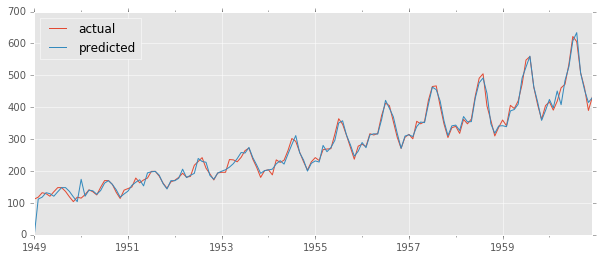

In [26]:
results_df.plot(figsize=(10, 4))